In [1]:
import numpy as np
from tqdm import tqdm
# import gym
# from gym import spaces

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

from ReplayBuffer import ReplayBuffer
from environment import Environment

In [2]:
device = T.device("cuda" if T.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
env = Environment(state = np.array([0, 1, 0, -1, 0, 0]), mu = 0.05, m = 1, g = 9.81, thetamin = 0, thetamax = np.pi, phimin = 0, phimax = 2*np.pi, Tmin = 0, Tmax = 20, dT = 1, dt = 0.02, dphi = 0.2*np.pi, dtheta = 0.2*np.pi)
action_space = env.actionspace()
print(action_space.shape)

(1386, 3)


In [4]:
class DQN(nn.Module):
    def __init__(self, lr, input_dim, fc1_dims, fc2_dims, output_dim):
        super(DQN, self).__init__()
        self.input_dim = input_dim
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.output_dim = output_dim

        self.fc1 = nn.Linear(input_dim, fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        f3 = 0.005
        self.fc3 = nn.Linear(fc2_dims, output_dim)
        T.nn.init.uniform_(self.fc3.weight.data, -f3, f3)
        T.nn.init.uniform_(self.fc3.bias.data, -f3, f3)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        self.to(device)
    def forward(self, x):
       x = F.relu(self.bn1(self.fc1(x)))
       x = F.relu(self.bn2(self.fc2(x)))
       x= self.fc3(x)

       return x

In [5]:
class DQN_Agent(object):
    def __init__(self, lr, input_dim, input_dims_buff, fc1_dims, fc2_dims, gamma, n_actions, epsilon, batch_size,
                 buffer_size=1000000, eps_end=0.01, eps_dec=5e-7, N = 32, tau = 0.9):
        self.lr = lr
        self.input_dim = input_dim
        self.gamma = gamma
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.tau = tau
        self.N = N
        self.memory = ReplayBuffer(buffer_size, input_dims_buff)
        self.QNetwork = DQN(lr, input_dim, fc1_dims, fc2_dims, n_actions)
        self.QNetwork_target = DQN(lr, input_dim, fc1_dims, fc2_dims, n_actions)
        self.update_network_parameters()
    
    def update_network_parameters(self, tau = None):
        if tau is None:
            tau = self.tau
        qn_params = self.QNetwork.named_parameters()
        target_qn_params = self.QNetwork_target.named_parameters()
        qn_dict = dict(qn_params)
        target_qn_dict = dict(target_qn_params)
        for name in qn_dict:
            qn_dict[name] = tau*qn_dict[name].clone() + (1-tau)*target_qn_dict[name].clone()
        self.QNetwork_target.load_state_dict(qn_dict)

    def choose_action(self, state, epsilon = None):
        if epsilon is None:
            epsilon = self.epsilon
        self.QNetwork.eval()
        if np.random.random() >= epsilon:
            state = T.tensor(state, dtype=T.float).to(device)
            actions = self.QNetwork.forward(state)
            action = T.argmax(actions).item()
            # print(action)
        else:
            action = np.random.choice(self.n_actions, replace=False)
        self.QNetwork.train()
        return action_space[action]

    def remember(self, state, action, reward, new_state, done):
        self.memory.add_sample(state, action, reward, new_state, done)
    
    def learn(self, step):
        if self.memory.count < self.batch_size:
            return
        states, actions, rewards, new_states, dones = self.memory.return_sample(self.batch_size)

        states = T.tensor(states, dtype=T.float32).to(device)
        actions = T.tensor(actions, dtype=T.float32).to(device)
        rewards = T.tensor(rewards, dtype=T.float32).to(device)
        new_states = T.tensor(new_states, dtype=T.float32).to(device)
        dones = T.tensor(dones).to(device)

        self.QNetwork.eval()
        all_qsas = self.QNetwork.forward(states)
        # print(all_qsas.shape)
        opt_qsas = T.max(all_qsas, dim = 1)[0]
        self.QNetwork_target.eval()
        # next_states = 
        next_qsas = self.QNetwork_target.forward(new_states)
        next_opt_qsas = T.max(next_qsas, dim = 1)[0]

        bellmanoptimality = []
        for j in range(self.batch_size):
            bellmanoptimality.append(rewards[j] + self.gamma*next_opt_qsas[j]*dones[j])
        bellmanoptimality = T.tensor(bellmanoptimality).to(device)
        bellmanoptimality = bellmanoptimality.view(self.batch_size, 1)

        self.QNetwork.train()
        self.QNetwork.optimizer.zero_grad()
        opt_qsas = opt_qsas.view(self.batch_size, 1)
        loss = F.mse_loss(opt_qsas, bellmanoptimality.float())
        loss.backward()
        self.QNetwork.optimizer.step()

        if step % self.N == 0:
            self.update_network_parameters()

In [6]:
Agent = DQN_Agent(lr=0.001, input_dim=6, input_dims_buff = [6,3], fc1_dims=1024, fc2_dims=1024, gamma=0.99, n_actions=len(action_space), epsilon=0.5, batch_size=32, buffer_size=1000, eps_end=0.2, eps_dec=0.995, N=32, tau = 0.9)
np.random.seed(0)
num_episodes = 50
max_steps = 1500

Average_Rewards = []
for i in range(num_episodes):
    done = False
    step = 0
    env.reset()
    total_reward = []
    while not done and step < max_steps:
        action = Agent.choose_action(env.state)
        # print(step)
        # print(action)
        state, new_state, done = env.next_state(action) 
        if done:
            reward = -10000
        else:
            reward = env.reward1()
        Agent.remember(state, action, reward, new_state, done)
        Agent.learn(step)
        # print(step)  
        # state = new_state
        total_reward.append(reward)
        step += 1
    tr = 0
    for r in total_reward[::-1]:
        tr = Agent.gamma*tr + r
    # tr = tr/step
    tr1 = tr - Average_Rewards[-1] if len(Average_Rewards) > 0 else tr
    Average_Rewards.append(tr)
    if Agent.epsilon > Agent.eps_min:
        Agent.epsilon = Agent.epsilon*Agent.eps_dec
    print('episode ', i, 'score %.1f' % tr, 'steps ', step)

episode  0 score -4097.8 steps  1500
episode  1 score -4095.3 steps  1500
episode  2 score -3952.6 steps  1500
episode  3 score -3870.9 steps  1500
episode  4 score -3791.7 steps  1500


KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(len(Average_Rewards)), Average_Rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average Reward in DQN vs Episode')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
def plot_trajectory(states):
    x = [state[0] for state in states]
    y = [state[2] for state in states]
    z = [state[4] for state in states]

    vx = [state[1] for state in states]
    vy = [state[3] for state in states]
    vz = [state[5] for state in states]

    fig = plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    plt.plot(x, label = 'x')
    plt.plot(y, label = 'y')
    plt.plot(z, label = 'z')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(vx, label = 'vx')
    plt.plot(vy, label = 'vy')
    plt.plot(vz, label = 'vz')
    plt.legend()
    
    plt.show()

In [ ]:
def plot_actions(actions):
    T_values = [action[0] for action in actions]
    phi_values = [action[1] for action in actions]
    theta_values = [action[2] for action in actions]

    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    axs[0].plot(range(len(T_values)), T_values)
    axs[0].set_ylabel('T')
    axs[0].set_title('Trajectory of T')
    # axs[0].set_ylim(env.Tmin, env.Tmax)

    axs[1].plot(range(len(phi_values)), phi_values)
    axs[1].set_ylabel('phi')
    axs[1].set_title('Trajectory of phi')
    # axs[1].set_ylim(env.phimin, env.phimax)

    axs[2].plot(range(len(theta_values)), theta_values)
    axs[2].set_ylabel('theta')
    axs[2].set_title('Trajectory of theta')
    # axs[2].set_ylim(env.thetamin, env.thetamax)

    plt.xlabel('Time Step')
    plt.tight_layout()
    plt.show()

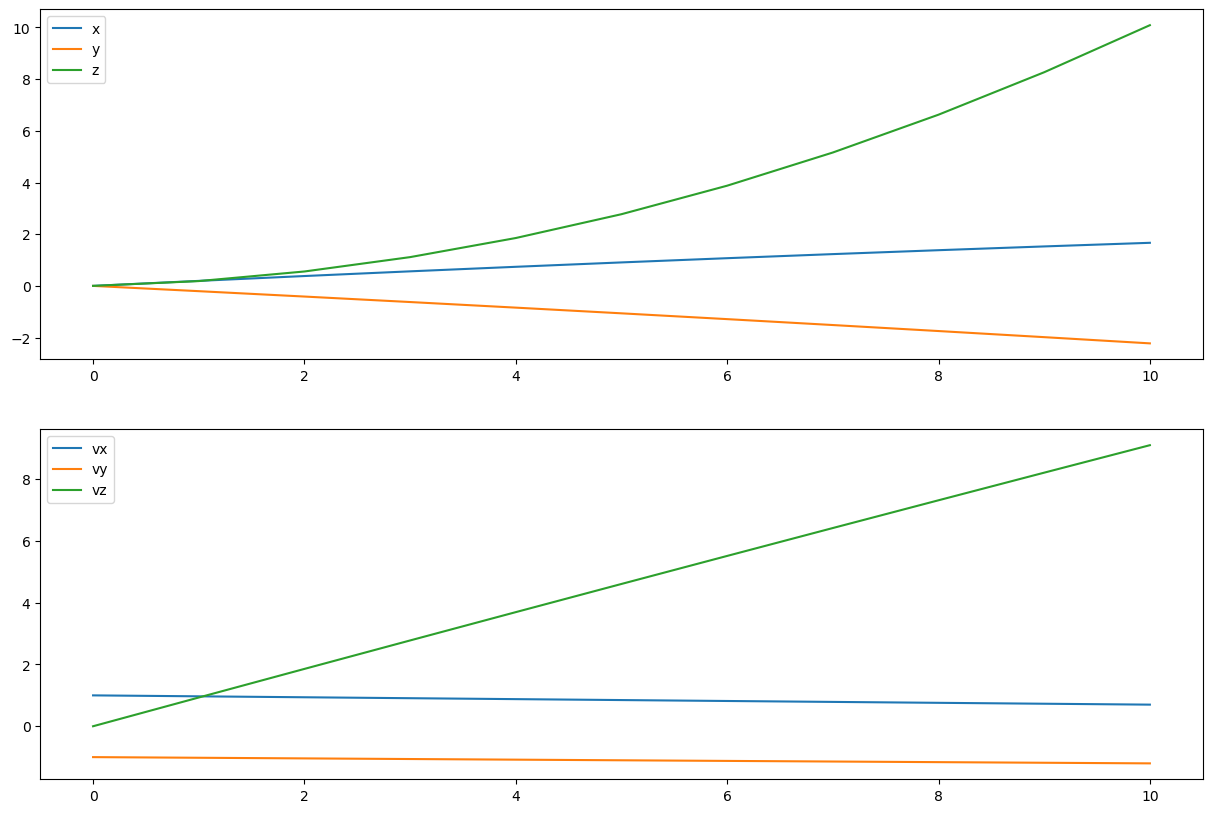

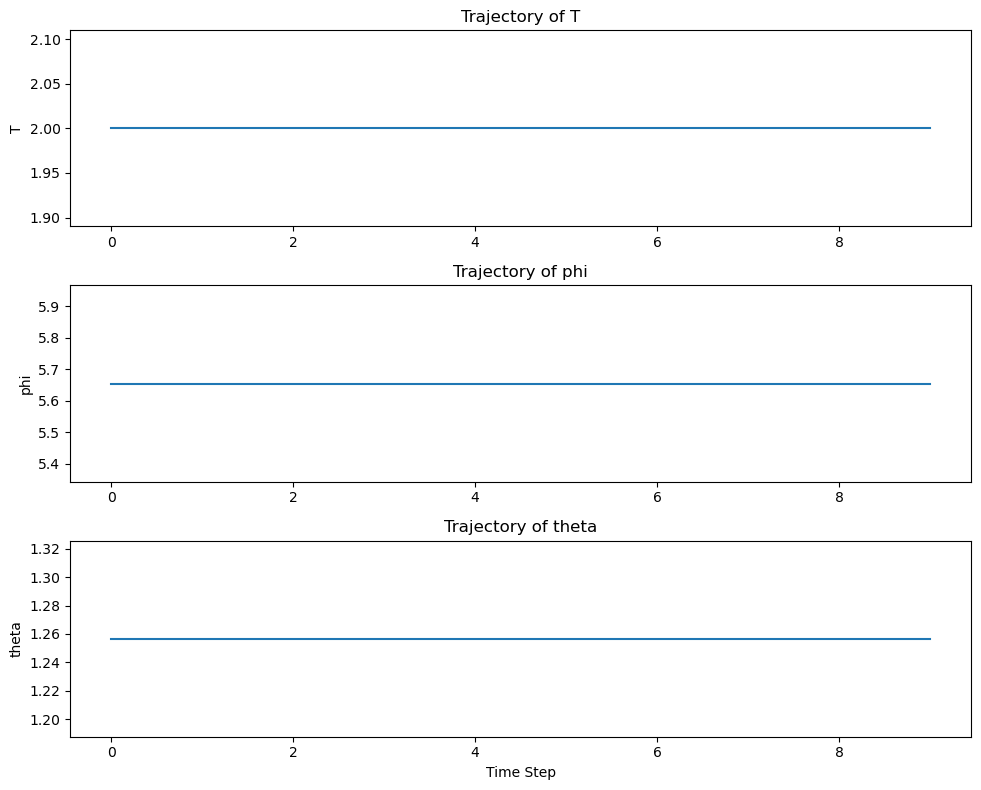

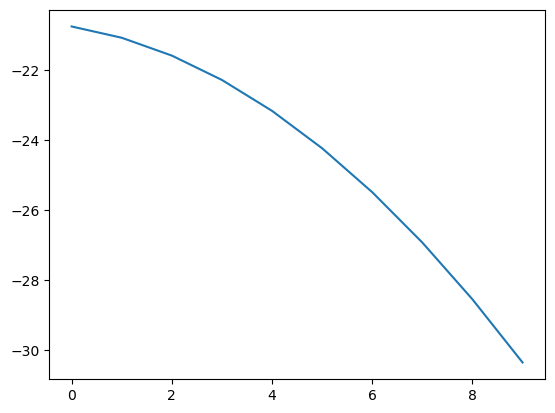

In [ ]:
max_steps = 10
Score  = 0

step = 0
state = [0, 1, 0, -1, 0, 0]
states = []
actions = []
states.append(state)
done = False
env.reset()
score = []
while not done and step < max_steps:
    action = Agent.choose_action(env.state, 0)
    # print(step)
    # print(action)
    actions.append(action)
    state, new_state, done = env.next_state(action)
    reward = env.reward1()
    # print(step)  
    # state = new_state
    states.append(env.state)
    score.append(reward)
    step += 1

states = np.array(states)
actions = np.array(actions)
score = np.array(score)
# save these two arrays to a file
np.save('states_DQN.npy', states)
np.save('actions_DQN.npy', actions)

plot_trajectory(states)
plot_actions(actions)
plt.plot(range(len(score)), score)